In [1]:
import numpy as np
import copy

In [2]:
class MatchingProblem:
    """Representation of a matching problem.  The goal
    is to find the row_ind and col_ind that sum to the lowest cost from a 
    cost matrix.
    
    
    Parameters
    ----------
    cost matrix : an NxM numpy array representing cost between 
    col_index: an index of M integers where the first N values would be summed to get min cost.
                

    """
    def __init__(self, cost_matrix, col_ind = None, mutations = 1):
        self.cost_matrix = cost_matrix
        self.mutations = mutations
        self.n_rows = cost_matrix.shape[0]
        self.n_cols = cost_matrix.shape[1]
        self.row_ind = np.arange(self.n_rows) #row index is sequential and does not mutate
        self.col_ind = col_ind
        
        if col_ind is None: #if no col_ind provided. initialize a random one
            self.col_ind = np.random.choice(np.arange(self.n_cols),
                                            size = self.n_cols,
                                            replace = False)

    def copy(self):
        """Return a copy of the current state."""
        new_mp = MatchingProblem(self.cost_matrix, self.col_ind)
        return new_mp

    def mutate(self):
        
        """ Perform N random pairwise position swaps in the column index
        where N is the number of mutations.
        
        *** I should later enhance this to perhaps 
        allow a separate cooling schedule for the mutation parameter to allow more mutations
        in the exploration phase and 1 mutation per iteration in the exploitation phase
        as the annealing method converges to a local hill climber"""
        new_col_ind = copy.deepcopy(self.col_ind)
        
        for _ in range(self.mutations):
            idx1 = np.random.choice(np.arange(self.n_rows)) #pick two indexes 
            idx2 = np.random.choice(np.arange(self.n_cols))
            new_col_ind[[idx1, idx2]] = new_col_ind[[idx2, idx1]] #swap
            
        mutated_mp = MatchingProblem(self.cost_matrix, new_col_ind)
        return mutated_mp
        
    def benchmark(self,trials = 1e4):
        """The uninformed brute force method: 
        perform N number of trials by generating a random column index and summing across the cost_matrix rows.
        Keep the best scoring one."""
        best = np.inf
        i = 0

        for _ in range(int(trials)):
            random_col_ind = np.random.choice(np.arange(self.n_cols),
                                            size = self.n_cols,
                                            replace = False)
            
            rand_value = -self.cost_matrix[self.row_ind, random_col_ind[:self.n_rows]].sum()
            best = min(rand_value, best)

        return best
    
    def get_value(self):
        """Calculate the total cost
        Returns
        -------
        float
            A floating point value with the total cost of the matching given by the col_ind 
            and row_ind
        
        """
        return self.cost_matrix[self.row_ind, self.col_ind[:self.n_rows]].sum()

In [3]:
def simulated_annealing(problem, schedule):
    """
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "mutate()" which "walks" the state to a neighboring one, 
        and a callable function "get_value()" which returns a fitness
        score for the state. 

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem

    """     
    
    switch = True
    t = 0
    current = problem.copy()
    
    while switch == True:
        
        T = schedule(t)
        if T< 1e-10:
            return current
        mutant = current.mutate()
        delta = mutant.get_value() - current.get_value() 
        
        if delta > 0:
            current = mutant.copy()
            continue
        else:
            p = np.exp(delta/T)
            if np.random.choice(2, p = [1-p, p]):
                current = mutant.copy()         
        t+=1

### Try to see if it will work

In [4]:
shape= (100,300)

fake_cost = np.random.rand(*shape)

In [5]:
from scipy.optimize import linear_sum_assignment

%time row_ind, col_ind = linear_sum_assignment(fake_cost)
fake_cost[row_ind, col_ind].sum()

CPU times: user 47.9 ms, sys: 1.76 ms, total: 49.6 ms
Wall time: 48.9 ms


0.41856693154671865

In [6]:
def schedule(time, alpha= 0.99999, temp=1e6):
    return temp * alpha ** time

mp = MatchingProblem(-fake_cost, mutations = 2)
%time solved_mp = simulated_annealing(mp, schedule)
-solved_mp.get_value()

CPU times: user 4min 57s, sys: 1.52 s, total: 4min 58s
Wall time: 5min 8s


0.4449797785448788

In [7]:
times_to_bench = 1e3
mp.benchmark(times_to_bench)

42.058665441237174

Text(0.5,1,'Cooling Schedules')

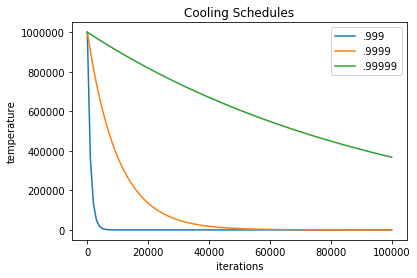

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

x = np.linspace(0, 1e5, num = 100)
plt.plot(x, schedule(x, alpha = .999), label = ".999")
plt.plot(x, schedule(x, alpha = .9999), label = ".9999")
plt.plot(x, schedule(x, alpha = .99999), label = ".99999")
plt.legend(loc = "upper right")
plt.xlabel("iterations")
plt.ylabel("temperature")
plt.title("Cooling Schedules")

### Set up a test and graph simulated annealing vs hungarian algo vs benchmark (assuming a 3x column to row cost matrix ratio)

In [10]:
import time
#write some wrapper functions to test easily
def timer_wrapper(solver, cost_matrix):
    start = time.time()
    value = solver(cost_matrix)
    time_delta = time.time() - start
    return value, time_delta

def lin_sum(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return cost_matrix[row_ind, col_ind].sum()
    
def sim_anneal(cost_matrix, alpha= 0.999, temp=1e6):
    def schedule(time, alpha= alpha, temp=temp):
        return temp * alpha ** time
    
    mp = MatchingProblem(-cost_matrix)
    solved_mp = simulated_annealing(mp, schedule)
    return -solved_mp.get_value()

def benchmark(cost_matrix):
    mp = MatchingProblem(-cost_matrix)
    return mp.benchmark(cost_matrix.shape[0])#*1e5)



In [11]:
#generate some shapes to test
rows = [int(_) for _ in np.linspace(100,1500, 15)]
cols = rows * np.array([3])
shapes =  zip(rows, cols)


In [12]:
#look at some of the shapes we will test, starting with the largest
shapes[::-5]

[(1500, 4500), (1000, 3000), (500, 1500)]

In [13]:
import pandas as pd
from functools import partial

algorithms = {"Hungarian": lin_sum, 
           "Benchmark":benchmark}

#try 3 different alphas
for a in[.999,.9999,.99999]:
    algorithms["Annealing_%s"%a] = partial(sim_anneal, alpha = a)

In [15]:

results = pd.DataFrame()
i=0
for shape in shapes:
    cost_matrix = np.random.rand(*shape)
    for k,v in algorithms.iteritems():
        
        value, time_delta = timer_wrapper(v,cost_matrix)
        if i%5==0:
            print k, shape, time_delta, value
        results = results.append([[k, shape, time_delta, value]])
    i+=1
results.columns = ["Algorithm", "Shape", "Time", "Score"]


Annealing_0.999 (100, 300) 2.83618497849 0.911228461442
Annealing_0.9999 (100, 300) 29.3942689896 0.459662784837
Benchmark (100, 300) 0.00405287742615 44.3185090032
Annealing_0.99999 (100, 300) 298.049221039 0.43244064222
Hungarian (100, 300) 0.0680270195007 0.422402306605
Annealing_0.999 (600, 1800) 4.02735686302 20.2685935836
Annealing_0.9999 (600, 1800) 35.5052919388 2.93413556615
Benchmark (600, 1800) 0.0462908744812 281.71301799
Annealing_0.99999 (600, 1800) 355.81629014 0.527973215776
Hungarian (600, 1800) 33.0387539864 0.363942584236
Annealing_0.999 (1100, 3300) 4.41156506538 58.749912284
Annealing_0.9999 (1100, 3300) 42.2029399872 8.01268240929
Benchmark (1100, 3300) 0.148047924042 516.849734495
Annealing_0.99999 (1100, 3300) 436.250437021 1.1911407455
Hungarian (1100, 3300) 212.001024961 0.370411210435


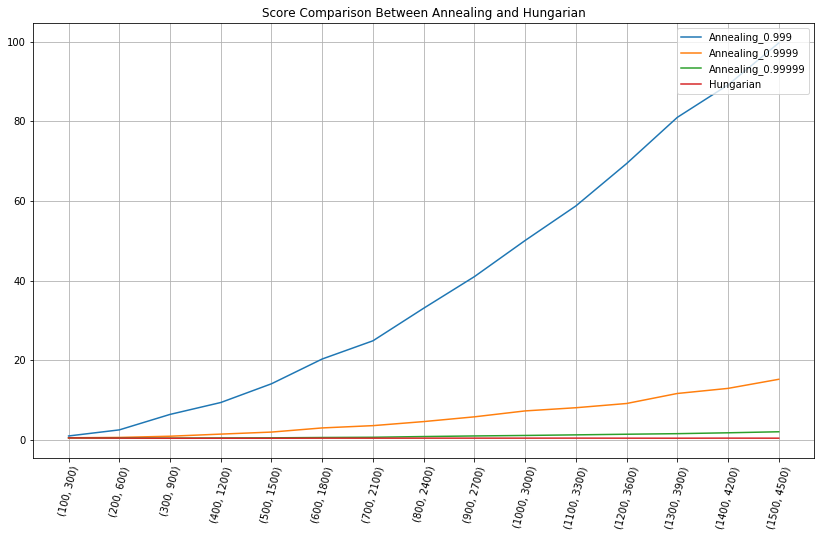

In [21]:
from IPython.core.pylabtools import figsize
figsize(14,8)


for k in algorithms.iterkeys():
    if k <> "Benchmark":
        graph = results[results.Algorithm == k]
        plt.plot(range(len(graph)), graph.Score, label = k)
plt.legend(loc = "upper right")
plt.grid()
plt.title("Score Comparison Between Annealing and Hungarian")
plt.xticks(range(len(graph)),graph.Shape, rotation = 75);


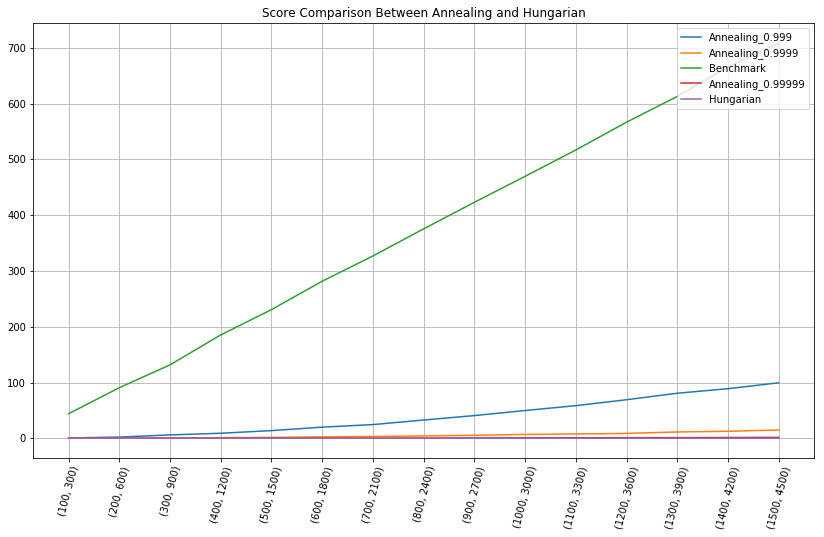

In [22]:
from IPython.core.pylabtools import figsize
figsize(14,8)


for k in algorithms.iterkeys():

    graph = results[results.Algorithm == k]
    plt.plot(range(len(graph)), graph.Score, label = k)
plt.legend(loc = "upper right")
plt.grid()
plt.title("Score Comparison Between Annealing and Hungarian")
plt.xticks(range(len(graph)),graph.Shape, rotation = 75);


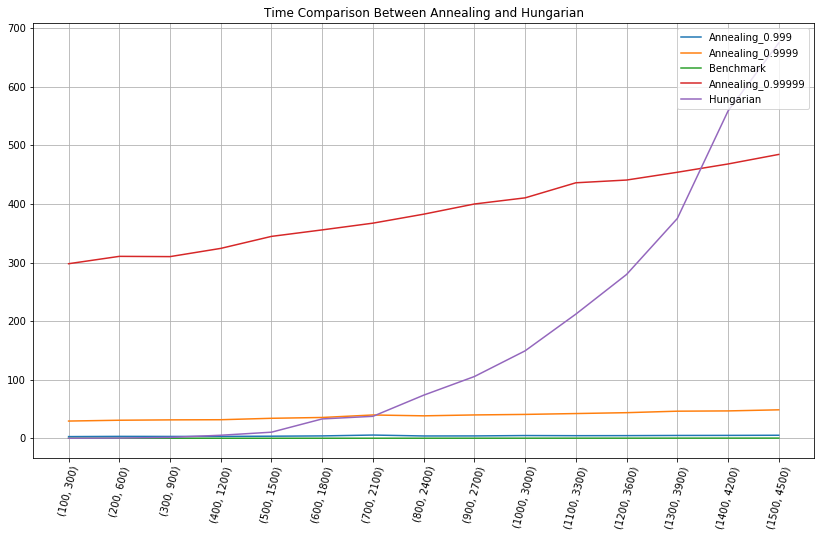

In [20]:

for k in algorithms.iterkeys():
    graph = results[results.Algorithm == k]
    plt.plot(range(len(graph)), graph.Time, label = k)
plt.legend(loc = "upper right")
plt.grid()
plt.title("Time Comparison Between Annealing and Hungarian")
plt.xticks(range(len(graph)),graph.Shape, rotation = 75);


In [18]:
results.to_csv("sim_annealing_test.csv")

In [ ]:
# TODO: re-run analysis by using a different generator function for the cost
#matrix to see if the different solution spaces